<a href="https://colab.research.google.com/github/musman2012/imaging-research/blob/master/OpenCV/ResearchPaperImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mat4py
import matplotlib.pyplot as plt
import numpy as np
import h5py
from mat4py import loadmat

#data = loadmat('/content/2macula.mat')


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import matplotlib.image as mpimg
import cv2 as cv

#matfile = io.loadmat('/content/2macula.mat')


In [5]:

## This implementation is based on following research paper:
## https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf

This code is an implementation of [this research paper](https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf)


In [7]:
def show_img(img2show):
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()

In [7]:
## Apply denoising (Median Filters [23,24,37] )
## 3 × 3 pixels 
def apply_median_filter(in_img):
  filtered_img = cv.medianBlur(img, 3)
  #show_img(filtered_img)
  return filtered_img

In [4]:
## Apply K-Mean Clustering (Color Quantization)
def apply_k_mean_clustering(in_img):
  Z = in_img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((in_img.shape))
  return res2
  #cv.imshow('res2',res2)
  #show_img(res2)
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(res2)
  #plt.show()
  #cv.waitKey(0)
  #cv.destroyAllWindows()


In [8]:
### Apply Canny Edge Detector
def apply_canny_edge(in_img):
  edges = cv.Canny(in_img,50,200)

  return edges
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(edges)
  #plt.show()

In [15]:
def find_high_intensity_areas(in_img):
  resultr, resultc = [], []
  for col in range(cols):
    for row in range(rows):
      if in_img[row, col] > 250:
        #temp = (row, col)
        resultr.append(row)
        resultc.append(col)
      
  return (resultr, resultc)

In [16]:
## now we know that 
def find_RPE_col(rows, cols, in_loc):
  rpe_pos = []
  counter = 0

  for r in rows:
    if r == in_loc:
      break
    counter += 1

  return cols[counter]

## here we know the index of high intensity row



In [17]:
(hi_rows, high_cols) = find_high_intensity_areas(gray)
#print(hi_rows.median())

In [13]:
## Detect position of ILM
def detect_ilm(in_img):
  #print(edges.shape) ## 390, 508 ==> Rows x Cols
  rows, cols = in_img.shape
  #center = cols//2
  ilm_pos = []
  seg_img = np.zeros((rows, cols), np.uint8)
  for col in range(cols-1, 0, -1):
    for row in range(rows):
      if in_img[row, col] == 255:
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_pos.append(pos)
        #print("In the loop", row, col)
        break
  
  return ilm_pos
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(seg_img)
  #plt.show()

In [13]:
gray = cv.cvtColor(filtered_img, cv.COLOR_BGR2GRAY)
# perform a naive attempt to find the (x, y) coordinates of
# the area of the image with the largest intensity value
#(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(gray)
#cv.circle(img_ilm, maxLoc, 5, (255, 0, 0), 2)


In [22]:
def segment_rpe(gray_img, rpe_col, rpe_row, t_cols):
  rpe_pos = []
  sliding_row = rpe_row
  int_thr = 175
  for c in range(rpe_col, 0, -1):
    for index in range(0, 10):
      if gray_img[sliding_row + index, c] > int_thr:
        sliding_row += index
        temp = (sliding_row, c)
        rpe_pos.append(temp)
        break
      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_pos.append(temp)
        break
  
  sliding_row = rpe_row
  for c in range(rpe_col, t_cols):
    for index in range(0, 10):
      if gray_img[sliding_row + index, c] > int_thr:
        sliding_row += index
        temp = (sliding_row, c)
        rpe_pos.append(temp)
        break
      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_pos.append(temp)
        break
  
  return rpe_pos

In [64]:
def seg_fluid(gray_img, ilm_pos, rpe_pos, thershld, thershld2):
  ## length of rows should be equal to number of cols
  ilm_rows, ilm_cols, rpe_rows, rpe_cols = [],[],[],[]
  MAX_ROW, MIN_ROW = 0,0
  NUM_ROWS, NUM_COLS = gray_img.shape
  fluid_pos = []

  for ilms in ilm_pos:
    (row, col) = ilms
    ilm_rows.append(row)
    ilm_cols.append(col)

  for rpes in rpe_pos:
    (row, col) = rpes
    rpe_rows.append(row)
    rpe_cols.append(col)

  MAX_ROW = max(rpe_rows)
  MIN_ROW = min(ilm_rows)

  print(len(ilm_rows))
  print(gray_img.shape)

  counter = len(ilm_rows)

  for c in range(NUM_COLS):
    counter -= 1
    if counter >= 0:
      starting_row = ilm_rows[counter]
      #print("Starting row is ", starting_row)
    else:
      print("Counter is high", counter)
    for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      if gray_img[r, c] > thershld and gray_img[r, c] < thershld2:
        temp = (r, c)
        #resultr.append(row)
        fluid_pos.append(temp)
    

  return fluid_pos


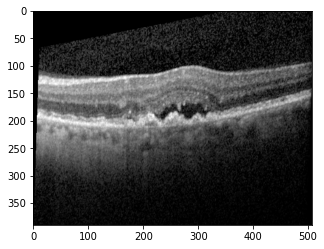

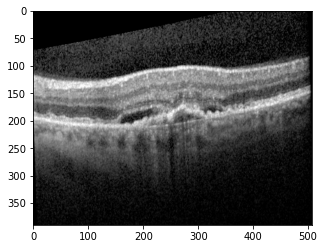

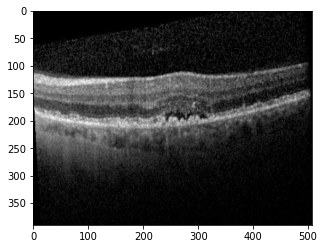

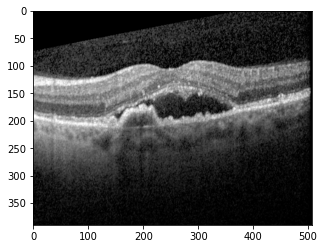

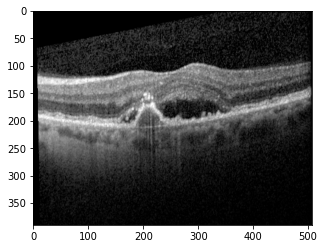

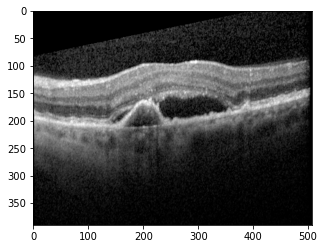

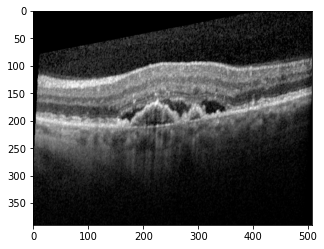

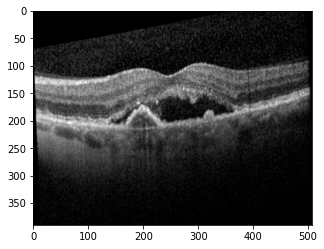

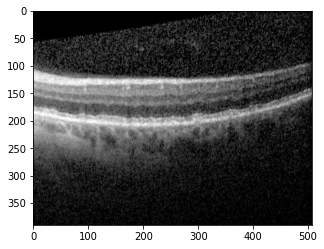

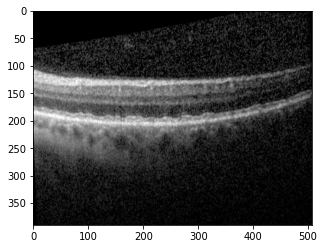

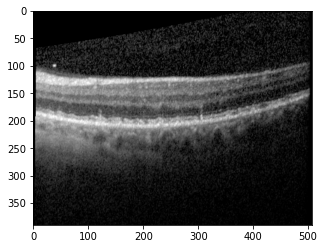

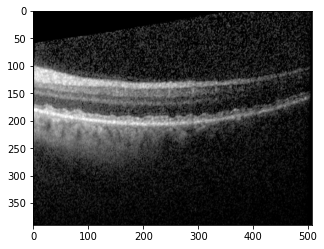

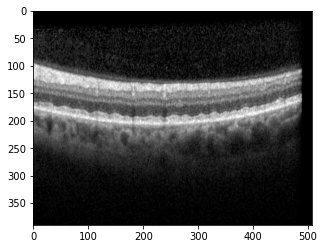

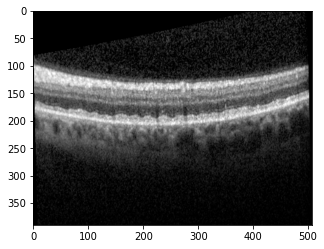

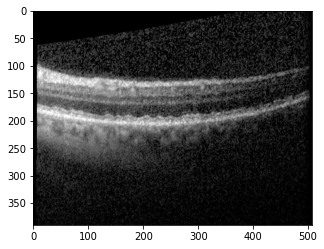

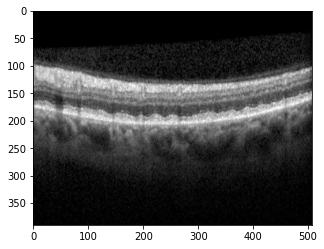

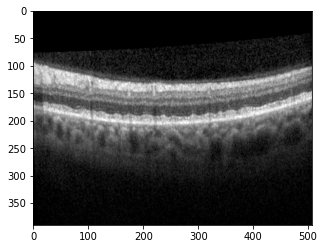

KeyboardInterrupt: ignored

In [14]:
import os


MIN_ROW = 10
MAX_ROW = 400
RANGE_THRESHOLD = 145

os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
image_files = os.listdir()
#os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
#for img_name in image_files:
#img_name = image_files[25]
#img = img[MIN_ROW:MAX_ROW,500:,:]
#new_name = 'cropped_'+img_name
#cv.imwrite(new_name, img)

for img_name in image_files:
  img = cv.imread(img_name)
  md_img = apply_median_filter(img)
  clus_img = apply_k_mean_clustering(md_img)
  ed_img = apply_canny_edge(clus_img)
  ilm_pos = detect_ilm(ed_img)

  gray = cv.cvtColor(md_img, cv.COLOR_BGR2GRAY)

  #count, th = 1, 10


  for ilm_position in ilm_pos:
    (row, col) = ilm_position
    segmented_scan_ilm_rpe_final[row:row+5, col, 0] = 255

  for rpe_position in rpe_pos:
    (row, col) = rpe_position
    segmented_scan_ilm_rpe_final[row:row+5, col, 1] = 255

  for f in fluid_pos:
    (row, col) = f
    segmented_scan_ilm_rpe_final[row:row+10, col, 2] = 255
  fig = plt.figure(figsize=(5, 5))

  plt.imshow(img)
  plt.show()


(390, 508, 3)


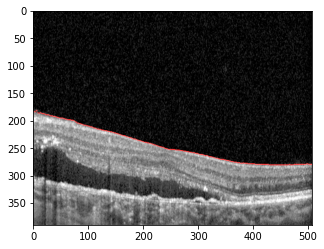

In [12]:
print(img.shape)
img_ilm = img.copy()
for position in ilm_pos:
  (row, col) = position
  img_ilm[row:row+2, col, 0] = 255

fig = plt.figure(figsize=(5, 5))
plt.imshow(img_ilm)
plt.show()

In [ ]:
print(filtered_img.shape)

(390, 508, 3)


## Detecting RPE (HRC)

In [ ]:
print(filtered_img.shape)

(390, 508, 3)


In [ ]:
print(filtered_img.shape)

(390, 508, 3)


In [ ]:
print("Helo")

Helo


In [14]:
from collections import Counter
my_dict = dict()
print(minVal, maxVal, minLoc, maxLoc)
print(gray.shape)

for col in range(cols):
  for row in range(rows):
    if gray[row, col] in my_dict:
      my_dict[gray[row, col]] += 1
    else:
      my_dict[gray[row, col]] = 1
      #print("In the loop", row, col)

print(my_dict)
#Counter(gray).keys()

0.0 255.0 (2, 0) (23, 236)
(390, 508)
{16: 2550, 6: 3911, 11: 3450, 3: 4751, 2: 5590, 15: 2675, 26: 1042, 19: 2086, 18: 2141, 5: 4322, 24: 1365, 17: 2367, 8: 3708, 27: 960, 13: 2893, 22: 1645, 4: 4713, 1: 5894, 0: 40550, 9: 3668, 14: 2809, 30: 617, 7: 3865, 10: 3482, 21: 1916, 31: 601, 23: 1672, 32: 449, 36: 259, 50: 288, 77: 318, 103: 394, 126: 590, 149: 762, 160: 551, 186: 202, 203: 168, 205: 125, 215: 95, 238: 31, 244: 31, 240: 37, 231: 35, 219: 85, 177: 323, 173: 381, 182: 245, 179: 261, 158: 661, 155: 675, 152: 659, 139: 708, 123: 551, 119: 596, 117: 633, 118: 539, 129: 715, 132: 651, 136: 728, 144: 735, 142: 682, 135: 733, 122: 670, 109: 438, 98: 414, 151: 653, 154: 761, 137: 724, 128: 662, 120: 599, 114: 526, 87: 378, 79: 323, 71: 386, 59: 382, 56: 344, 60: 359, 64: 415, 67: 397, 54: 356, 42: 177, 34: 372, 43: 226, 48: 241, 57: 348, 52: 329, 44: 230, 35: 273, 39: 286, 53: 347, 47: 185, 46: 265, 25: 1261, 37: 227, 104: 396, 145: 703, 170: 411, 202: 133, 204: 177, 217: 62, 185: 20

In [20]:
from scipy import stats
mode = stats.mode(hi_rows)
mean = np.mean(hi_rows)

print(mode[0], mean)

[342] 305.0514705882353


In [21]:
rpe_row = mode[0][0]
rpe_col = find_RPE_col(hi_rows, high_cols, rpe_row)
print("Row and Col = ", rpe_row, rpe_col)

Row and Col =  342 460


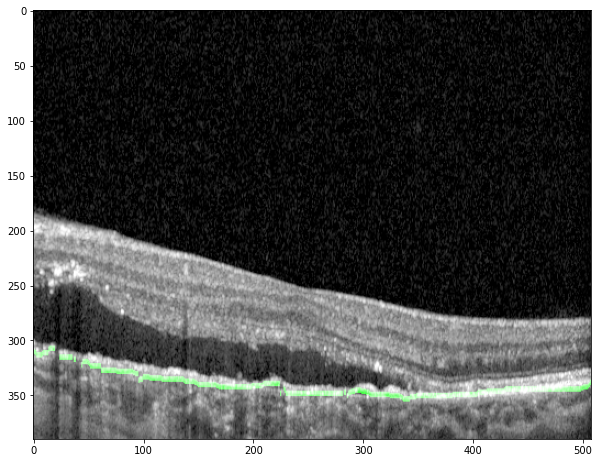

In [23]:
rpe_pos = segment_rpe(gray, rpe_col, rpe_row, gray.shape[1])
img_rpe = img.copy()
for position in rpe_pos:
  (row, col) = position
  img_rpe[row:row+5, col, 1] = 255

fig = plt.figure(figsize=(10, 10))
plt.imshow(img_rpe)
plt.show()

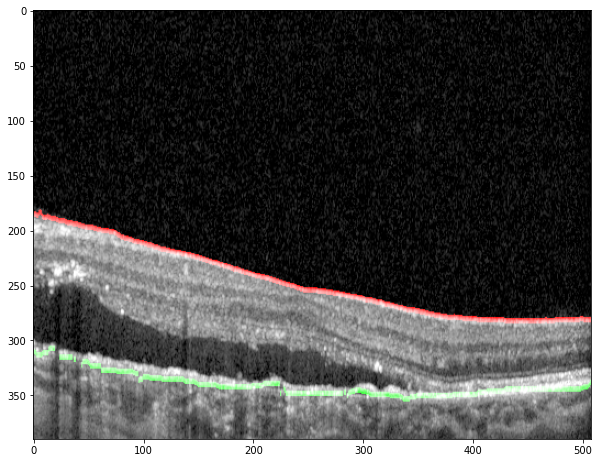

In [24]:
segmented_scan_ilm_rpe = img.copy()
for ilm_position in ilm_pos:
  (row, col) = ilm_position
  segmented_scan_ilm_rpe[row:row+5, col, 0] = 255

for rpe_position in rpe_pos:
  (row, col) = rpe_position
  segmented_scan_ilm_rpe[row:row+5, col, 1] = 255

fig = plt.figure(figsize=(10, 10))
plt.imshow(segmented_scan_ilm_rpe)
plt.show()

## Segmentation of Intra-Retinal Fluid

507
(390, 508)
Counter is high -1


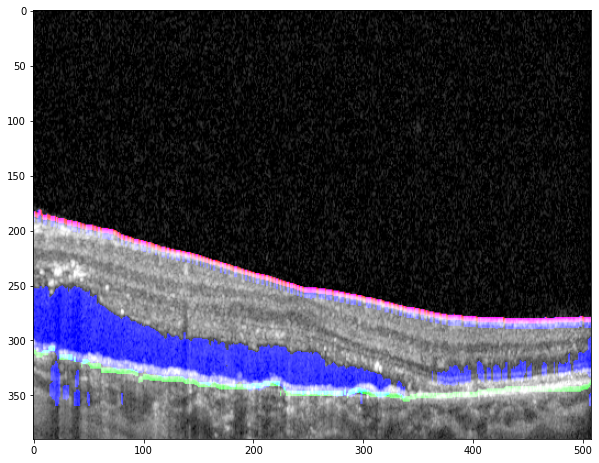

In [67]:
min_thrshld, max_thrshld = 0, 80 ## TODO-1 MAKE THESE INTENSITIES DYNAMIC
fluid_pos = seg_fluid(gray, ilm_pos, rpe_pos, min_thrshld, max_thrshld)

segmented_scan_ilm_rpe_final = img.copy()
for ilm_position in ilm_pos:
  (row, col) = ilm_position
  segmented_scan_ilm_rpe_final[row:row+5, col, 0] = 255

for rpe_position in rpe_pos:
  (row, col) = rpe_position
  segmented_scan_ilm_rpe_final[row:row+5, col, 1] = 255

for f in fluid_pos:
  (row, col) = f
  segmented_scan_ilm_rpe_final[row:row+10, col, 2] = 255



fig = plt.figure(figsize=(10, 10))
plt.imshow(segmented_scan_ilm_rpe_final)
plt.show()